In [1]:
import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from scipy.stats import beta, dirichlet
from operator import add
import matplotlib.pyplot as plt

## Variables

In [2]:
variables=list()
variables=['Enfermedad','Tratamiento','Reaccion','Final']

In [3]:
## Parametros

In [597]:
alpha=0.8

## Orden

In [5]:
orden=list()
orden=[['Tratamiento','Enfermedad'],
       ['Reaccion','Tratamiento'],
       ['Reaccion','Enfermedad'],
       ['Final','Enfermedad'],
       ['Final','Tratamiento'],
       ['Final','Reaccion']]

## True Causal Model From Environment:

In [6]:
model = BayesianModel([('Enfermedad', 'Final'), ('Tratamiento', 'Final'), ('Tratamiento', 'Reaccion'),
                       ('Reaccion', 'Final')])

cpd_e = TabularCPD(variable='Enfermedad', variable_card=2, values=[[0.7, 0.3]])
cpd_tr = TabularCPD(variable='Tratamiento', variable_card=2, values=[[0.5, 0.5]])

cpd_r_tr = TabularCPD(variable='Reaccion', variable_card=2, 
                   values=[[.7,.4], [.3,.6]], #vivir|farmaco vivir|cirugia #morir|farmaco morir|cirugia
                   evidence=['Tratamiento'],
                   evidence_card=[2])

cpd_f_e_tr_r = TabularCPD(variable='Final', variable_card=2, 
                   values=[[.6,0,.8,0,.4,0,.9,0],
                           [.4,1,.2,1,.6,1,.1,1]], #vivir|vivir,farmaco,a #morir|
                  evidence=['Enfermedad', 'Tratamiento','Reaccion'],
                  evidence_card=[2, 2,2])

model.add_cpds(cpd_e, cpd_tr, cpd_r_tr, cpd_f_e_tr_r)

infer = VariableElimination(model)
sampling = BayesianModelSampling(model)

## Inicializando modelo verdadero para simulaciones

In [7]:
class true_causal_model:
    def __init__(self,N,infer,sampling,model):
        self.num_variables=N
        self.infer=infer
        self.sampling=sampling
        self.true_model=model

    def action_simulator(self):
        response=dict()
        elements = [0,1]
        probabilities = [0.5,0.5]
        res=np.random.choice(elements, 1, p=probabilities)
        enf=np.random.choice(elements, 1, p=probabilities)
        response['Enfermedad']=res[0]
        response['Tratamiento']=enf[0]
        response['Reaccion']=self.infer.map_query(['Reaccion'],evidence={'Tratamiento': response['Tratamiento'],'Enfermedad': response['Enfermedad']})['Reaccion']
        response['Final']=self.infer.map_query(['Final'],evidence={'Tratamiento': response['Tratamiento'],'Enfermedad': response['Enfermedad'],'Reaccion':response['Reaccion']})['Final']
        return(response)
        

In [8]:
true_model_class=true_causal_model(4,infer,sampling,model)

In [9]:
true_model_class.action_simulator()

{'Enfermedad': 0, 'Final': 0, 'Reaccion': 0, 'Tratamiento': 0}

## Para simular:

In [728]:
class structure_learning:
    def __init__(self, alpha, variables, true_model,model_simulator, orden):
        self.local_model=true_model ## Este es el directamente creado con PGMPY, no la clase true_causal_model
        self.simulator=model_simulator.action_simulator
        self.a=alpha
        self.orden=orden
        self.variables=variables
        self.causas_posibles=list()
        self.beliefs=dict()
        self.rondas=1.0
    
    def print_variables(self):
        return(self.variables)
    
    def print_orden(self):
        return(self.orden)
    
    def possible_causes(self):
        for i in range(len(self.variables)):
            for j in range(len(self.variables)):
                if(self.variables[i] != self.variables[j]):
                    lista_temp=[self.variables[i],self.variables[j]]
                    if(lista_temp not in self.orden):
                        self.causas_posibles.append(lista_temp)
        return(self.causas_posibles)
    
    def print_possible_causes(self):
        return(self.causas_posibles)
    
    def initial_beliefs(self):
        self.causas_posibles=self.possible_causes()
        causas_posibles=self.causas_posibles
        for i in causas_posibles:
            i=str(i)
            self.beliefs[i]=np.random.rand(1).tolist()[0]
        return(self.beliefs)

    def observing_external(self):
        datos=self.simulator()
        return(datos)
    
    def belief_updating(self):
        self.rondas=self.rondas+1.0
        datos=self.observing_external()
        for i in self.causas_posibles:
            if(datos[i[0]]==1 and datos[i[1]]==1):
                i=str(i)
                self.beliefs[i]=self.beliefs[i]+((self.a)*(1.0-self.beliefs[i])/(self.rondas))
            elif(datos[i[0]]==1 and datos[i[1]]==0):
                i=str(i)
                self.beliefs[i]=((self.a)*(self.beliefs[i]))/(self.rondas)
 #           elif(datos[i[0]]==0 and datos[i[1]]==1):
 #               i=str(i)
 #               self.beliefs[i]=((self.a)*(self.beliefs[i]))/(self.rondas)
                #    if(datos[i[0]]==0 and datos[i[1]]==1):
                #        i=str(i)
                   # else:
                   #     if(datos[i[0]]==0 and datos[i[1]]==0):
#            else:
#                continue
        return(self.beliefs)

## Plotting

In [916]:
N=10

In [917]:
enfermedad_final=list()
enfermedad_reaccion=list()
enfermedad_tratamiento=list()
reaccion_final=list()
tratamiento_final=list()
tratamiento_reaccion=list()
resultados=dict()

In [918]:
aprendizaje=structure_learning(alpha,variables,model,true_model_class,orden)

In [919]:
initial=dict()

In [920]:
initial=aprendizaje.initial_beliefs()

In [921]:
enfermedad_final.append(initial["['Enfermedad', 'Final']"])
enfermedad_reaccion.append(initial["['Enfermedad', 'Reaccion']"])
enfermedad_tratamiento.append(initial["['Enfermedad', 'Tratamiento']"])
reaccion_final.append(initial["['Reaccion', 'Final']"])
tratamiento_final.append(initial["['Tratamiento', 'Final']"])
tratamiento_reaccion.append(initial["['Tratamiento', 'Reaccion']"])

In [922]:
for i in range(N):
    resultados=aprendizaje.belief_updating()
    enfermedad_final.append(resultados["['Enfermedad', 'Final']"])
    enfermedad_reaccion.append(resultados["['Enfermedad', 'Reaccion']"])
    enfermedad_tratamiento.append(resultados["['Enfermedad', 'Tratamiento']"])
    reaccion_final.append(resultados["['Reaccion', 'Final']"])
    tratamiento_final.append(resultados["['Tratamiento', 'Final']"])
    tratamiento_reaccion.append(resultados["['Tratamiento', 'Reaccion']"])

In [923]:
resultados

{"['Enfermedad', 'Final']": 0.9053517220708662,
 "['Enfermedad', 'Reaccion']": 0.005027860461384057,
 "['Enfermedad', 'Tratamiento']": 0.0021153181671272983,
 "['Reaccion', 'Final']": 0.7643280469541139,
 "['Tratamiento', 'Final']": 0.9312999482006625,
 "['Tratamiento', 'Reaccion']": 0.8021487517236219}

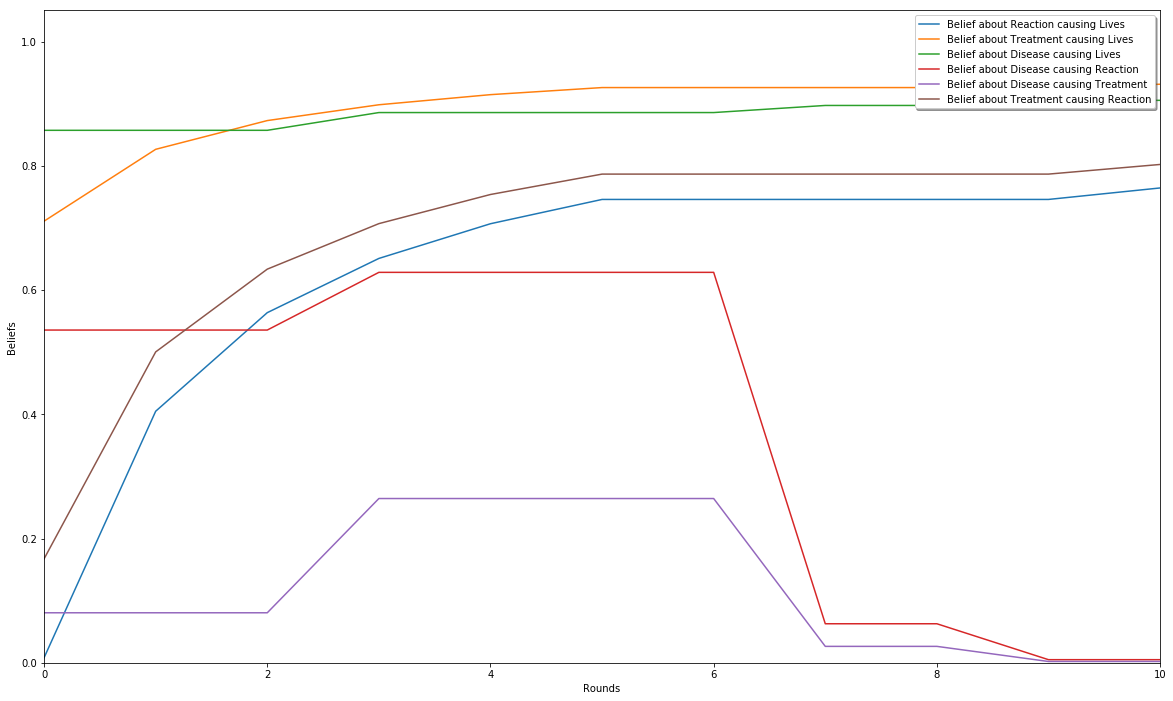

In [925]:
plt.figure(figsize=(20,12))
plt.plot(reaccion_final,label='Belief about Reaction causing Lives')
plt.plot(tratamiento_final,label='Belief about Treatment causing Lives')
plt.plot(enfermedad_final,label='Belief about Disease causing Lives')
plt.plot(enfermedad_reaccion,label='Belief about Disease causing Reaction')
plt.plot(enfermedad_tratamiento,label='Belief about Disease causing Treatment')
plt.plot(tratamiento_reaccion,label='Belief about Treatment causing Reaction')
leg = plt.legend(loc='upper right', shadow=True, fontsize=10)
plt.xlim([0, N])
plt.ylim([0, 1.05])
plt.xlabel("Rounds")
plt.ylabel("Beliefs")
plt.savefig('results_10.png')